## Basic dynamics for simulator comparison

### Imports and definitions

In [1]:
import sys
import os
from subprocess import run, PIPE
import json
import shutil
import re
from pathlib import Path
#from IPython.display import Image

current_folder = globals()['_dh'][0]
sys.path.append(os.path.join(current_folder, "../../analysis"))
import averageFileColumnsAdvanced as afc
import plotSimResultsComparisonMeanSEM as plotc
from utilityFunctions import *

src_dir = os.path.abspath(os.path.join(current_folder, "../../simulation-code/build_scripts_misc")) # directory where the simulation code is located
bin_dir = os.path.abspath(os.path.join(current_folder, "../../simulation-bin/run_binary_misc")) # directory where the simulation binaries are located
config = {
             "synapses" : {
                 "h_0" : 4.20075,
                 "early_phase" : {
                     "theta_p" : 3.0, 
                     "theta_d" : 1.2,
                     "Ca_pre" : 1.0,
                     "Ca_post" : 0.2758}
             }
         } # model configuration, required for simulation call and plotting

### Function to call compilation

In [2]:
#########################################################
# compileSimulationCode
# Compiles the simulation code for a given case
# - case: name of the special case to be used (as defined in 'simulation-code/SpecialCases.hpp')
def compileSimulationCode(case):
    
    os.chdir(src_dir)
    cmnd = "/bin/sh"
    args = f"compile_{case}"
    result = run([cmnd, args], stdout=PIPE, stderr=PIPE, universal_newlines=True)
    print(result.stdout, result.stderr)

### Function to run simulation batches

In [3]:
#########################################################
# runSimulationBatches
# Runs a number of batches with a certain number of trials for a given protocol;
# subsequently averages over trials and over batches
# - protocol: name of the protocol to be used (as defined in 'simulation-code/StimulusProtocols.cpp')
# - t_max: total duration of the simulation in seconds
# - num_batches: number of batches
# - trials_per_batch: number of trials per batch
# - remove_existing [optional]: if True, remove existent data root directory
# - only_average [optional]: if True, only do averaging over batches
def runSimulationBatches(protocol, t_max, num_batches, trials_per_batch, remove_existing = True, only_average = False):
    
    os.chdir(bin_dir)
    data_root = os.path.abspath(f"./stand-alone_data_{protocol}_{num_batches}x{trials_per_batch}")
    data_path_averaged = os.path.join(data_root, "./averaged_traces")
    
    if not only_average:
        compileSimulationCode(f"2N1S_{protocol}")
        if not os.path.isdir(data_root):
            os.mkdir(data_root)
        elif remove_existing:
            shutil.rmtree(data_root)
            os.mkdir(data_root)
        os.makedirs(data_path_averaged) # an error is thrown if the directory exists already
        for batch in range(num_batches):
            batch_name = str(batch + 1)
            data_path_batch = os.path.join(data_root, batch_name)
            os.mkdir(data_path_batch)

            # simulate trials
            for trial in range(trials_per_batch):
                print("--------------------------------------------")
                print(f"Batch {batch_name}, trial {trial + 1}:")
                os.chdir(data_path_batch)
                cmnd = f"../../2N1S_{protocol}.out"
                args = [f"-learn={protocol.upper()}",
                        f"-Ca_pre={config['synapses']['early_phase']['Ca_pre']}",
                        f"-Ca_post={config['synapses']['early_phase']['Ca_post']}",
                        f"-purpose=", 
                        f"-t_max={t_max}"]
                result = run([cmnd, *args], stdout=PIPE, stderr=PIPE, universal_newlines=True)
                if trial == 0 and batch == 0:
                    result_stdout_cleaned = re.sub(".*Progress: .*\n?", "", result.stdout)
                    print(result_stdout_cleaned, result.stderr)
                else:
                    print("<output suppressed>")
                os.chdir(bin_dir)
                
            # average over trials
            # columns: 1: Time, 2: V(0), 3: I_tot(0), 4: p^C(0), 5: V(1), 6: I_tot(1), 7: p^C(1), 8: h(1,0), 9: z(1,0), 10: Ca(1,0)
            afc.averageFileColumns(f'{data_path_averaged}/{batch_name}.txt', data_path_batch, f'{protocol.upper()}', [], '_data.txt', [2,8,9,10,4], skip_first_line=True, col_sep='\t\t')
            
    # average over batches
    # columns: 1: Time, 2: mean of V(0), 3: std. dev. of V(0), 4: mean of h(1,0), 5: std. dev. of h(1,0), 
    #          6: mean of z(1,0), 7: std. dev. of z(1,0), 8: mean of Ca(1,0), 9: std. dev. of Ca(1,0),
    #          10: mean of p^C(0), 11: std. dev. of p^C(0)
    afc.averageFileColumns(f'{data_root}/meta_mean_averaged_traces.txt', data_root, 'averaged_traces', [], '.txt', [2,4,6,8,10], skip_first_line=False, col_sep='\t\t') # mean averaging
    afc.averageFileColumns(f'{data_root}/meta_stdev_averaged_traces.txt', data_root, 'averaged_traces', [], '.txt', [3,5,7,9,11], skip_first_line=False, col_sep='\t\t') # std.dev. averaging
    
    # plotting
    json.dump(config, open(os.path.join(data_root, f"config_{protocol}.json"), "w"))
    plotc.plotSingle("stand-alone", protocol, num_batches, trials_per_batch, store_dir=data_root, file_format = "png", time_unit=1000) # already shows them in Jupyter
    #file_to_plot = os.path.join(data_root, f"mean_stand-alone_{protocol}.svg")
    #![protocol](file_to_plot) # not necessary, anyway produces an error (warning?)
    #Image(filename = os.path.join(data_root, f"mean_stand-alone_{protocol}.svg")) # not necessary, anyway does not support svg

### Basic early-phase dynamics

Task: averaging columns [2, 4, 6, 8, 10], from files matching ['*.txt'] in folders of the protocol 'averaged_traces'
Found 1 matching folder:
 ['/home/jlubo/Desktop/Network Consolidation Code/GitLab Repository/memory-consolidation-stc/simulation-bin/run_binary_misc/stand-alone_data_basic_early_10x100/averaged_traces']
Found 10 matching files in '/home/jlubo/Desktop/Network Consolidation Code/GitLab Repository/memory-consolidation-stc/simulation-bin/run_binary_misc/stand-alone_data_basic_early_10x100/averaged_traces':
 ['/home/jlubo/Desktop/Network Consolidation Code/GitLab Repository/memory-consolidation-stc/simulation-bin/run_binary_misc/stand-alone_data_basic_early_10x100/averaged_traces/1.txt'
 '/home/jlubo/Desktop/Network Consolidation Code/GitLab Repository/memory-consolidation-stc/simulation-bin/run_binary_misc/stand-alone_data_basic_early_10x100/averaged_traces/10.txt'
 '/home/jlubo/Desktop/Network Consolidation Code/GitLab Repository/memory-consolidation-stc/simulation-bin/run_

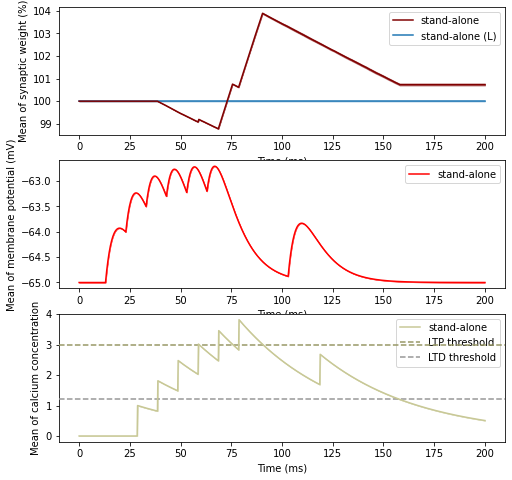

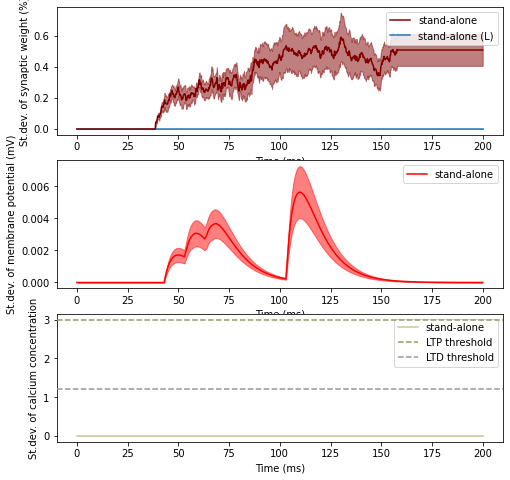

In [4]:
#runSimulationBatches("basic_early", 0.2, 10, 100, remove_existing = True)
runSimulationBatches("basic_early", 0.2, 10, 100, only_average = True)

### Basic late-phase dynamics

Task: averaging columns [2, 4, 6, 8, 10], from files matching ['*.txt'] in folders of the protocol 'averaged_traces'
Found 1 matching folder:
 ['/home/jlubo/Desktop/Network Consolidation Code/GitLab Repository/memory-consolidation-stc/simulation-bin/run_binary_misc/stand-alone_data_basic_late_10x10/averaged_traces']
Found 10 matching files in '/home/jlubo/Desktop/Network Consolidation Code/GitLab Repository/memory-consolidation-stc/simulation-bin/run_binary_misc/stand-alone_data_basic_late_10x10/averaged_traces':
 ['/home/jlubo/Desktop/Network Consolidation Code/GitLab Repository/memory-consolidation-stc/simulation-bin/run_binary_misc/stand-alone_data_basic_late_10x10/averaged_traces/1.txt'
 '/home/jlubo/Desktop/Network Consolidation Code/GitLab Repository/memory-consolidation-stc/simulation-bin/run_binary_misc/stand-alone_data_basic_late_10x10/averaged_traces/10.txt'
 '/home/jlubo/Desktop/Network Consolidation Code/GitLab Repository/memory-consolidation-stc/simulation-bin/run_binary_m

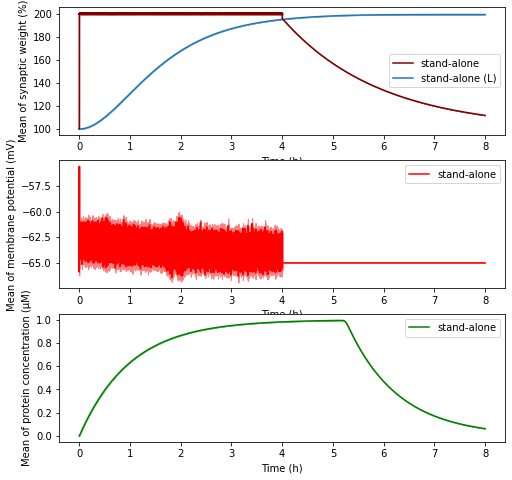

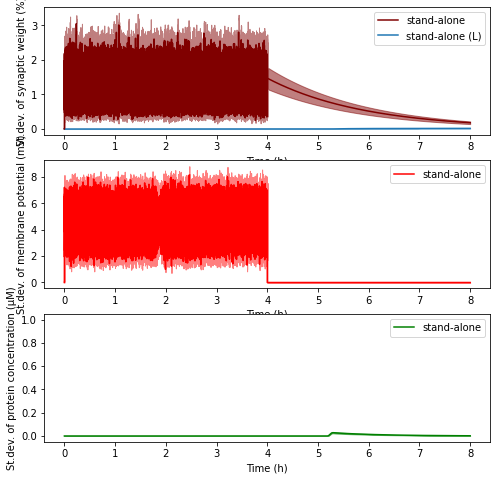

In [5]:
#runSimulationBatches("basic_late", 28800.0, 10, 10, remove_existing = True)
runSimulationBatches("basic_late", 28800.0, 10, 10, only_average = True)

### Function to run "smallnet3" simulation

In [6]:
#########################################################
# runSmallnet3Simulation
# Runs a simulation with the network 'smallnet3' (consisting of 4 excitatory and 1 inhibitory neurons);
# first, a TRIPLET stimulus is applied to neuron 0, later, a single stimulus is applied to neuron 0
# - protocol: protocol to be used ("10s-recall" or "8h-recall")
# - remove_existing [optional]: if True, remove existent data root directory
def runSmallnet3Simulation(protocol, remove_existing = True):
    
    compileSimulationCode("smallnet_ou")
    os.chdir(bin_dir)
    data_root = os.path.abspath(f"./stand-alone_data_{protocol}")

    if not os.path.isdir(data_root):
        os.mkdir(data_root)
    elif remove_existing:
        shutil.rmtree(data_root)
        os.mkdir(data_root)
    shutil.copy("smallnet_ou.out", f"{data_root}/smallnet_ou.out")
    shutil.copy("connections_smallnet3.txt", f"{data_root}/connections.txt")

    if protocol == "smallnet3_10s-recall":
        recall_prot = "F100D1at20.0"
        t_max = 25
    elif protocol == "smallnet3_8h-recall":
        recall_prot = "F100D1at28810.0"
        t_max = 28820
    else:
        raise ValueError(f"Protocol {protocol} not supported.")
    
    os.chdir(data_root)
    cmnd = f"./smallnet_ou.out"
    args = ["-dt=2e-4", 
            "-Nl_exc=2", 
            "-Nl_inh=1", 
            f"-t_max={t_max}", 
            "-N_stim=25", 
            "-learn=TRIPLETat10.0", 
            f"-recall={recall_prot}", 
            "-w_ei=2", 
            "-w_ie=4.0", 
            "-w_ii=4.0", 
            "-I_0=0", 
            "-sigma_WN=0",
            f"-theta_p={config['synapses']['early_phase']['theta_p']}", 
            f"-theta_d={config['synapses']['early_phase']['theta_d']}", 
            "-sigma_plasticity=0", 
            "-output_period=1", 
            "-purpose=smallnet3 det, dt=0.2ms, 8h, with recall"]
    result = run([cmnd, *args], stdout=PIPE, stderr=PIPE, universal_newlines=True)
    result_stdout_cleaned = re.sub(".*Progress: .*\n?", "", result.stdout)
    print(result_stdout_cleaned, result.stderr)
    
    # find and copy data
    rawpaths = Path(".")
    for path_obj in sorted(rawpaths.iterdir()): # loop through elements in this directory
        if path_obj.is_dir():
            dir_path = str(path_obj)
            if hasTimestamp(dir_path):
                rawpaths_inside = Path(dir_path)
                for path_inside_obj in sorted(rawpaths_inside.iterdir()):
                    file_path = str(path_inside_obj)
                    if "_data.txt" in file_path:
                        #shutil.copy(file_path, f"{data_root}/meta_mean_averaged_traces.txt")
                        print(f"Data file found: '{file_path}'.")
                        
                        # "averaging" over one trial (necessary to obtain the right format)
                        # -- choosing dynamics of neuron 1 and synapse 0->1
                        afc.averageFileColumns(f'{data_root}/meta_mean_averaged_traces.txt', data_root, getTimestamp(dir_path), [], '_data.txt', [5,17,18,19,7], skip_first_line=True, col_sep='\t\t') 
                break
                       
    # plotting
    os.chdir(bin_dir)
    json.dump(config, open(os.path.join(data_root, f"config_{protocol}.json"), "w"))
    print("Plotting dynamics of neuron 1 and synapse 0->1...")
    plotc.plotSingle("stand-alone", protocol, 0, 1,
                     store_dir = data_root, time_unit=1000)
    #file_to_plot = os.path.join(data_root, f"mean_stand-alone_{protocol}.svg")

### "smallnet3" simulation with 10s-"recall"
Employing a small network to demonstrate learning and recall protocols that can be used for large network simulations of memory formation and consolidation (cf. https://doi.org/10.1038/s42003-021-01778-y).

 In file included from NetworkSimulation.cpp:47,
                 from NetworkMain.cpp:8:
SpecialCases.hpp:145:3: warning: #warning "Special case: SMALLNET_OU" [-Wcpp]
  145 |  #warning "Special case: SMALLNET_OU"
      |   ^~~~~~~

----------------------------------------------------------------------------------------------------
End time of neuromodulation set to end time of the simulation.
Connections successfully imported.
Network simulation with N_exc = 4, N_inh = 1, t_max = 25 s (24-02-05_12-01-13)
Learning protocol: TRIPLETat10.0
Recall protocol: F100D1at20.0
Description: smallnet3 det, dt=0.2ms, 8h, with recall
Connectivity: p_c = 0.1, tau_syn = 5 ms, w_ei = 2, w_ie = 4, w_ii = 4
Other parameters: I_0 = 0 nA, sigma_WN = 0 nA s^1/2, N_stim = 25
E->E connectivity: 41.6667 % (expected: 10.0000 %)
I->E connectivity: 50.0000 % (expected: 10.0000 %)
E->I connectivity: 50.0000 % (expected: 10.0000 %)
I->I connectivity: -nan % (expected: 10.0000 %)
Total number of connections: 9

Elap

/home/jlubo/Desktop/Network Consolidation Code/GitLab Repository/memory-consolidation-stc/notebooks/simulator_comparison_basic/../../analysis/averageFileColumnsAdvanced.py:169: RuntimeWarning: invalid value encountered in divide
  data_var /= (sample_number - 1)


Plotting dynamics of neuron 1 and synapse 0->1...


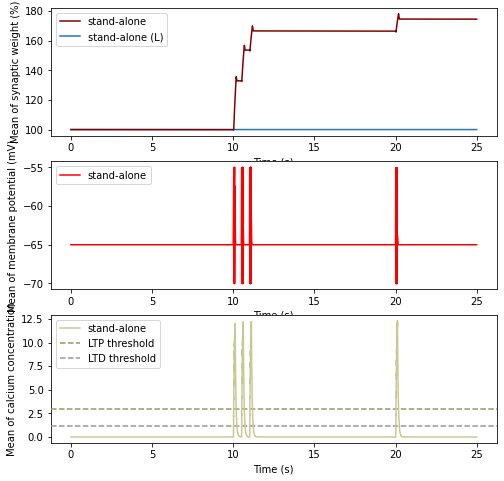

In [7]:
runSmallnet3Simulation("smallnet3_10s-recall")

### "smallnet3" simulation with 8h-"recall"
Employing a small network to demonstrate learning and recall protocols that can be used for large network simulations of memory formation and consolidation (cf. https://doi.org/10.1038/s42003-021-01778-y).

 In file included from NetworkSimulation.cpp:47,
                 from NetworkMain.cpp:8:
SpecialCases.hpp:145:3: warning: #warning "Special case: SMALLNET_OU" [-Wcpp]
  145 |  #warning "Special case: SMALLNET_OU"
      |   ^~~~~~~

----------------------------------------------------------------------------------------------------
End time of neuromodulation set to end time of the simulation.
Connections successfully imported.
Network simulation with N_exc = 4, N_inh = 1, t_max = 28820 s (24-02-05_12-01-37)
Learning protocol: TRIPLETat10.0
Recall protocol: F100D1at28810.0
Description: smallnet3 det, dt=0.2ms, 8h, with recall
Connectivity: p_c = 0.1, tau_syn = 5 ms, w_ei = 2, w_ie = 4, w_ii = 4
Other parameters: I_0 = 0 nA, sigma_WN = 0 nA s^1/2, N_stim = 25
E->E connectivity: 41.6667 % (expected: 10.0000 %)
I->E connectivity: 50.0000 % (expected: 10.0000 %)
E->I connectivity: 50.0000 % (expected: 10.0000 %)
I->I connectivity: -nan % (expected: 10.0000 %)
Total number of connections: 9

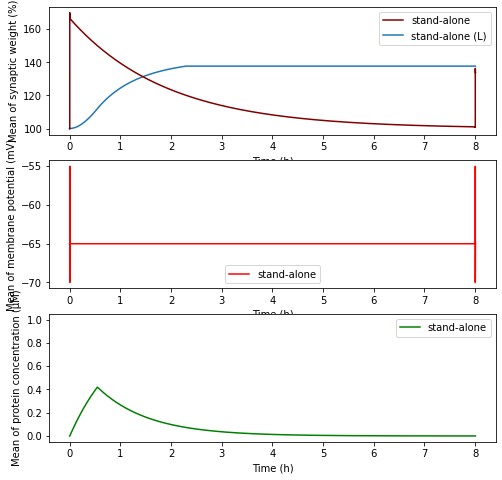

In [8]:
runSmallnet3Simulation("smallnet3_8h-recall")